# Find optimal partition number

In [1]:
import math, random
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform

## constants

In [21]:
#matfile = "kwad006.csv"
matfile = "pairwisedistancematrix_heuristicDX52_66.csv"
delta_level = 0.05
delta_threshold = 0.0 # will be set to average lowest 5% distance
cutoff = 0.995 #for proportion of intra-cluster distances less than delta_threshold
num_reps = 1000
min_clusters = 2
max_clusters = 64
random.seed(42)

## Read distance matrix from .csv file

In [22]:
df = pd.read_csv(matfile)
#save and remove sample names from df
labels = df['Seq_ID'].tolist()
df = df.drop('Seq_ID', 1) 
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66
0,9.037181,11.310012,11.310012,119.769464,89.317930,159.581062,62.753713,171.690908,216.725545,191.266098,...,110.611034,120.549231,212.649287,99.749110,180.451644,128.020750,212.649287,48.001943,190.426852,131.401396
1,11.310012,9.036872,11.310012,119.769464,89.317930,159.581062,62.753713,171.690908,216.725545,191.266098,...,110.611034,120.549231,212.649287,99.749110,180.451644,128.020750,212.649287,48.001943,190.426852,131.401396
2,11.310012,11.310012,9.036558,119.769464,89.317930,159.581062,62.753713,171.690908,216.725545,191.266098,...,110.611034,120.549231,212.649287,99.749110,180.451644,128.020750,212.649287,48.001943,190.426852,131.401396
3,119.769464,119.769464,119.769464,7.262898,135.729987,203.602630,104.709707,219.747038,246.188354,271.808208,...,163.511701,207.939548,260.051317,132.774181,225.787657,114.543266,260.051317,112.725333,220.521255,26.757740
4,89.317930,89.317930,89.317930,135.729987,8.874093,186.896270,115.728870,172.905496,258.486433,201.492638,...,93.059522,133.148270,258.523314,98.575908,172.305454,101.720210,258.523314,40.636509,239.135129,144.804903


In [23]:
# convert square matrix form into a condensed nC2 array
distance_matrix = df.to_numpy()
num_strains = len(distance_matrix)
# Set the diagonals to zero
np.fill_diagonal(distance_matrix, 0)
distance_array = ssd.squareform(distance_matrix)

## Perform heirarchical clustering

In [24]:
linkage_matrix = sch.linkage(distance_array, method='ward')

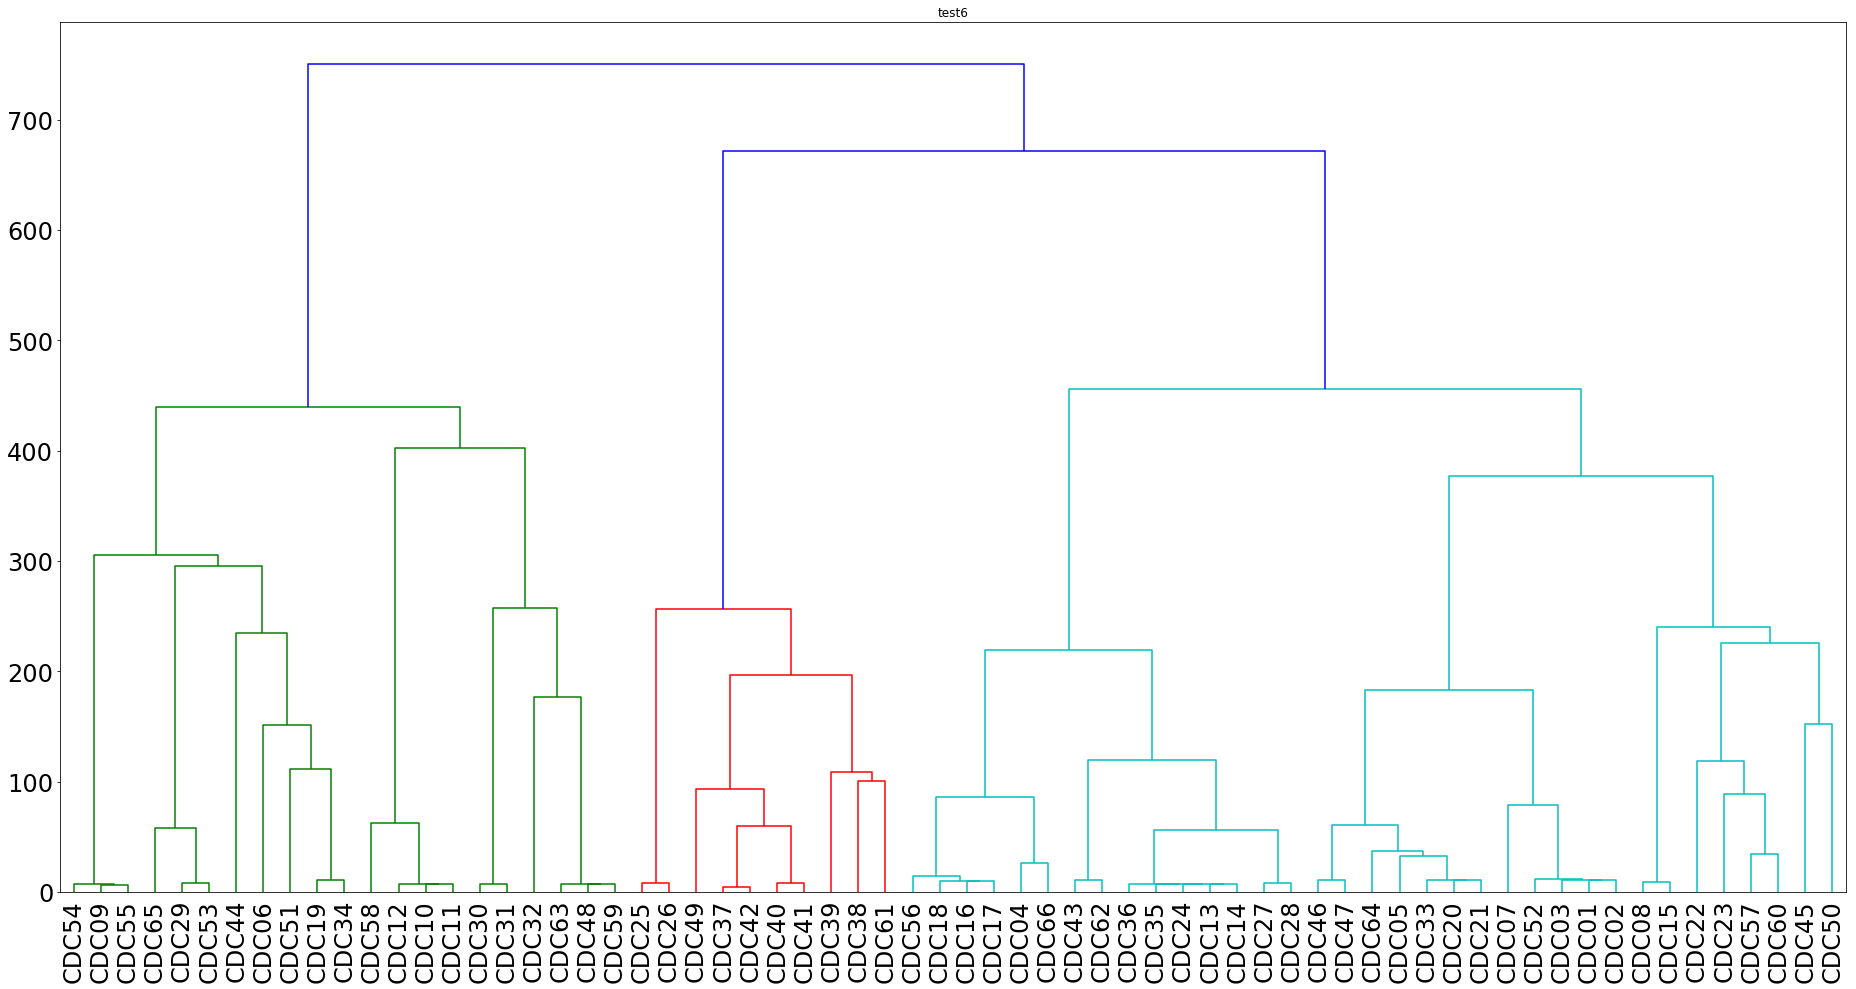

In [25]:
#font = {'size'   : 48}
#matplotlib.rc('font', **font)

plt.figure(figsize=(32, 16))
plt.title("test6")
dend = sch.dendrogram(linkage_matrix, labels=labels, show_leaf_counts=False)
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=24)
ax.tick_params(axis='y', which='major', labelsize=24)
plt.savefig('t.png')

## Populate clusters

In [26]:
def pool(clusters, nc):
    clust_pool = [ [] for _ in range(nc)]
    for i in range(len(clusters)):
        cnum = clusters[i][0]
        clust_pool[cnum].append(i)
    return clust_pool

## Determine max number of clusters that contain more than one strain each

In [27]:
for max_num_clust in range(min_clusters, max_clusters):
    clusters = sch.cut_tree(linkage_matrix, max_num_clust)
    counts = [0 for _ in range(max_num_clust)]
    for c in clusters:
        counts[c[0]] += 1
    minct = min(counts)
    if minct < 2:
        max_num_clust -= 1
        break
print("max number of clusters is", max_num_clust)
clusters = sch.cut_tree(linkage_matrix, max_num_clust)
clust_pool = pool(clusters, max_num_clust)
clust_pool

max number of clusters is 12


[[0, 1, 2, 4, 6, 19, 20, 32, 45, 46, 51, 63],
 [3, 12, 13, 15, 16, 17, 23, 26, 27, 34, 35, 42, 55, 61, 65],
 [5, 18, 33, 43, 50],
 [7, 14],
 [8, 53, 54],
 [9, 10, 11, 57],
 [21, 22, 44, 49, 56, 59],
 [24, 25],
 [28, 52, 64],
 [29, 30],
 [31, 47, 58, 62],
 [36, 37, 38, 39, 40, 41, 48, 60]]

## assign species by first split

In [28]:
#species66 = [1,1,1,1,1,2,1,1,2,2,2,2,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,2,2,2,2,1,2,1,1,1,1,1,1,1,1,1,2,1,1,1,2,1,1,2,1,2,2,2,1,1,2,2,1,1,1,2,1,2,1]
species_arr = sch.cut_tree(linkage_matrix, 2)
species_arr += 1 #1 or 2
species = [species_arr[i][0] for i in range(len(species_arr))]

## Determine delta threshold

In [29]:
target = 3 #species 1, 2 or 3 for both
n_choose = 1000 #find smallest cluster (probably 2)
for c in clust_pool:
    n_choose = min(n_choose, len(c))
num_sampled = 0    
for cl in clust_pool:
    if (species[cl[0]] & target) > 0:
        num_sampled += n_choose
compares = num_sampled * (num_sampled - 1) // 2
rank = math.floor(delta_level * float(compares))
print(rank, delta_level, compares, num_reps)


13 0.05 276 1000


In [30]:
delta_threshold = np.zeros(compares)
for _ in range(num_reps):
    dlist = np.zeros(compares)
    samples = []
    n = 0
    for cl in clust_pool:
        if (species[cl[0]] & target) > 0:
            items = random.sample(cl, n_choose)
            samples.extend(items)
    k = 0
    for i in range(len(samples)):
        a = samples[i]
        for j in range(i+1, len(samples)):
            b = samples[j]
            dlist[k] = distance_matrix[a][b]
            k += 1       
    sorted_array = np.sort(dlist)
    delta_threshold += sorted_array
delta_threshold /= float(num_reps)
print("delta threshold", delta_threshold[rank])

delta threshold 109.58930133495046


## Find optimal number of clusters

In [31]:
def check_cluster(delta_threshold):
    for num_clust in range(min_clusters, max_clusters):
        clusters2 = sch.cut_tree(linkage_matrix, num_clust)
        clust_pool2 = pool(clusters2, num_clust)
        count_all = 0
        count_high = 0
        for cl in clust_pool2:
            for i in range(len(cl)):
                a = cl[i]
                for j in range(i+1, len(cl)):
                    b = cl[j]
                    dist = distance_matrix[a][b]
                    count_all += 1
                    if dist > delta_threshold:
                        count_high += 1
        #print(num_clust, count_high, count_all)
        if 1.0 - float(count_high) / float(count_all) > cutoff:
            break
    return num_clust, clusters2

In [32]:
num_clust, clusters2 = check_cluster(delta_threshold[rank])
print(num_clust)

24


## find optimal clusters for each threshold

In [33]:
x = []
y = []
for i in range(math.ceil(0.4 * compares)): 
    num_clust, _ = check_cluster(delta_threshold[i])
    delta_level1 = (i+1.0) / float(compares)
    print(i+1,  delta_level1, delta_threshold[i], num_clust)
    x.append(num_clust)
    y.append(delta_threshold[i])

1 0.0036231884057971015 6.751741806999974 63
2 0.007246376811594203 6.915924420629967 63
3 0.010869565217391304 7.701306336425972 56
4 0.014492753623188406 8.316627831858085 52
5 0.018115942028985508 12.359683561414952 39
6 0.021739130434782608 24.23536179923896 38
7 0.025362318840579712 40.435707541879935 35
8 0.028985507246376812 57.23875848696491 29
9 0.03260869565217391 72.41275269228001 27
10 0.036231884057971016 85.2791873147401 25
11 0.03985507246376811 94.56008054238012 25
12 0.043478260869565216 100.5063477714301 24
13 0.04710144927536232 105.49527548217023 24
14 0.050724637681159424 109.58930133495046 24
15 0.05434782608695652 113.26072042204032 22
16 0.057971014492753624 116.69971782596026 22
17 0.06159420289855073 119.64463499317023 20
18 0.06521739130434782 122.46863718423002 20
19 0.06884057971014493 124.97819163623001 20
20 0.07246376811594203 127.34444147407004 20
21 0.07608695652173914 129.64854939217966 20
22 0.07971014492753623 131.71667487439953 20
23 0.083333333333

## List cluster for each strain

In [34]:
clust = []
for i in range(num_strains):
    clust.append((clusters2[i][0] + 1, labels[i]))
clust.sort()
for c in clust:
    print(c[1], c[0])

CDC01 1
CDC02 1
CDC03 1
CDC07 1
CDC52 1
CDC04 2
CDC16 2
CDC17 2
CDC18 2
CDC56 2
CDC66 2
CDC05 3
CDC20 3
CDC21 3
CDC33 3
CDC46 3
CDC47 3
CDC64 3
CDC06 4
CDC08 5
CDC15 5
CDC09 6
CDC54 6
CDC55 6
CDC10 7
CDC11 7
CDC12 7
CDC58 7
CDC13 8
CDC14 8
CDC24 8
CDC27 8
CDC28 8
CDC35 8
CDC36 8
CDC19 9
CDC34 9
CDC22 10
CDC23 11
CDC57 11
CDC60 11
CDC25 12
CDC26 12
CDC29 13
CDC53 13
CDC65 13
CDC30 14
CDC31 14
CDC32 15
CDC37 16
CDC40 16
CDC41 16
CDC42 16
CDC49 16
CDC38 17
CDC61 17
CDC39 18
CDC43 19
CDC62 19
CDC44 20
CDC45 21
CDC48 22
CDC59 22
CDC63 22
CDC50 23
CDC51 24


## Distribution of all distances

2145


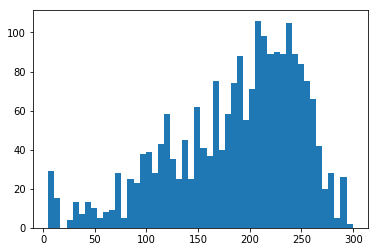

In [35]:
dlist = []
for i in range(num_strains):
    for j in range(i + 1, num_strains):
        d = round(distance_matrix[i][j], 4)
        dlist.append(d)
print(len(dlist))
plt.hist(dlist, bins = 50)
plt.show()

## Distribution of sampled distances (M2)

276


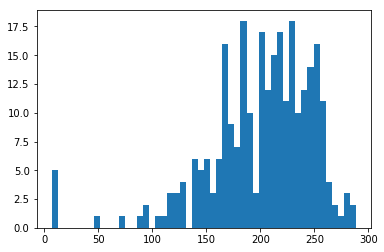

In [36]:
target = 3
dlist = np.zeros(compares)
samples = []
n = 0
for cl in clust_pool:
    if (species[cl[0]] & target) > 0:
        items = random.sample(cl, n_choose)
        samples.extend(items)
k = 0
for i in range(len(samples)):
    a = samples[i]
    for j in range(i+1, len(samples)):
        b = samples[j]
        dlist[k] = distance_matrix[a][b]
        k += 1  
print(compares)        
plt.hist(dlist, bins = 50)
plt.show()